# Assement 3

Prepared by: Ray Mcgregor

In [1]:
# Import Libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix
from scipy import stats
from sklearn.preprocessing import label_binarize

import re

# Import Dataset

In [3]:

column_names = [
"Sex","Length","Diameter","Height","Whole_weight","Shucked_weight","Viscera_weight","Shell_weight","Rings"]
raw_data = pd.read_csv('abalone.data', header=None, names=column_names)
# Dataset source: http://archive.ics.uci.edu/ml/datasets/Abalone
raw_data


,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


## Format Data

In [4]:
data_df = raw_data.copy()
data_df

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


## Convert Rings to be a Categorical Variable

In [5]:
#data_df['Ring Age'] = data_df['Rings'].astype('category')
invalid_rings = []

for i in range(len(data_df)):
    if data_df.loc[i, 'Rings'] <= 7:
        category = 1
    elif data_df.loc[i, 'Rings'] <= 10:
        category = 2
    elif data_df.loc[i, 'Rings'] <= 15:
        category = 3
    elif data_df.loc[i, 'Rings'] > 15:
        category = 4
    else:
        invalid_rings.append(data_df.loc[i, 'Rings'])

    data_df.loc[i, 'Ring Age'] = category

# print counts for each ring age in ascending order based on the ring age index
print(data_df['Ring Age'].value_counts().sort_index())
print()
print(data_df['Ring Age'].describe())
print(f"Invalid Examples Detected: ", invalid_rings)




1.0     839
2.0    1891
3.0    1186
4.0     261
Name: Ring Age, dtype: int64

count    4177.000000
mean        2.208044
std         0.831638
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         4.000000
Name: Ring Age, dtype: float64
Invalid Examples Detected:  []


## Data Preprocessing

In [6]:
# Null Values
nulls = data_df.isnull().sum()
print("Missing values:\n", nulls)

Missing values:
 Sex               0
Length            0
Diameter          0
Height            0
Whole_weight      0
Shucked_weight    0
Viscera_weight    0
Shell_weight      0
Rings             0
Ring Age          0
dtype: int64


In [7]:
# exclude non-numeric columns
numeric_data = data_df.select_dtypes(include=[np.number])

Q1 = numeric_data.quantile(0.25)
Q3 = numeric_data.quantile(0.75)
IQR = Q3 - Q1

# Detect outliers
outliers = ((numeric_data < (Q1 - 1.5 * IQR)) | (numeric_data > (Q3 + 1.5 * IQR))).any(axis=1)
print("Number of rows with outliers:", outliers.sum())
outliers.describe()

Number of rows with outliers: 396


count      4177
unique        2
top       False
freq       3781
dtype: object

In [8]:
# Select only numerical columns
numerical_df = data_df.select_dtypes(include=['number'])

# Initialize a dictionary to hold outlier details
outliers_info = {}

# Calculate IQR and detect outliers for each column
for column in numerical_df.columns:
    Q1 = numerical_df[column].quantile(0.25)
    Q3 = numerical_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = numerical_df[(numerical_df[column] < lower_bound) | (numerical_df[column] > upper_bound)]

    # Store information about outliers
    outliers_info[column] = {
        'IQR': IQR,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Number of Outliers': outliers.shape[0],
        'Outliers Details': outliers
    }

# Print the outlier information for each column
for column, info in outliers_info.items():
    print(f"Column: {column}")
    print(f"  IQR: {info['IQR']}")
    print(f"  Lower Bound: {info['Lower Bound']}")
    print(f"  Upper Bound: {info['Upper Bound']}")
    print(f"  Number of Outliers: {info['Number of Outliers']}")
    print(f"  Outliers Details:\n{info['Outliers Details']}\n\n")


Column: Length
  IQR: 0.16499999999999998
  Lower Bound: 0.20250000000000004
  Upper Bound: 0.8624999999999999
  Number of Outliers: 49
  Outliers Details:
      Length  Diameter  Height  Whole_weight  Shucked_weight  Viscera_weight  \
148    0.175     0.130   0.055        0.0315          0.0105          0.0065   
149    0.170     0.130   0.095        0.0300          0.0130          0.0080   
236    0.075     0.055   0.010        0.0020          0.0010          0.0005   
237    0.130     0.100   0.030        0.0130          0.0045          0.0030   
238    0.110     0.090   0.030        0.0080          0.0025          0.0020   
239    0.160     0.120   0.035        0.0210          0.0075          0.0045   
305    0.200     0.145   0.060        0.0370          0.0125          0.0095   
306    0.165     0.120   0.030        0.0215          0.0070          0.0050   
321    0.190     0.145   0.040        0.0380          0.0165          0.0065   
465    0.175     0.125   0.050        0.0235

### Visualize Outliers

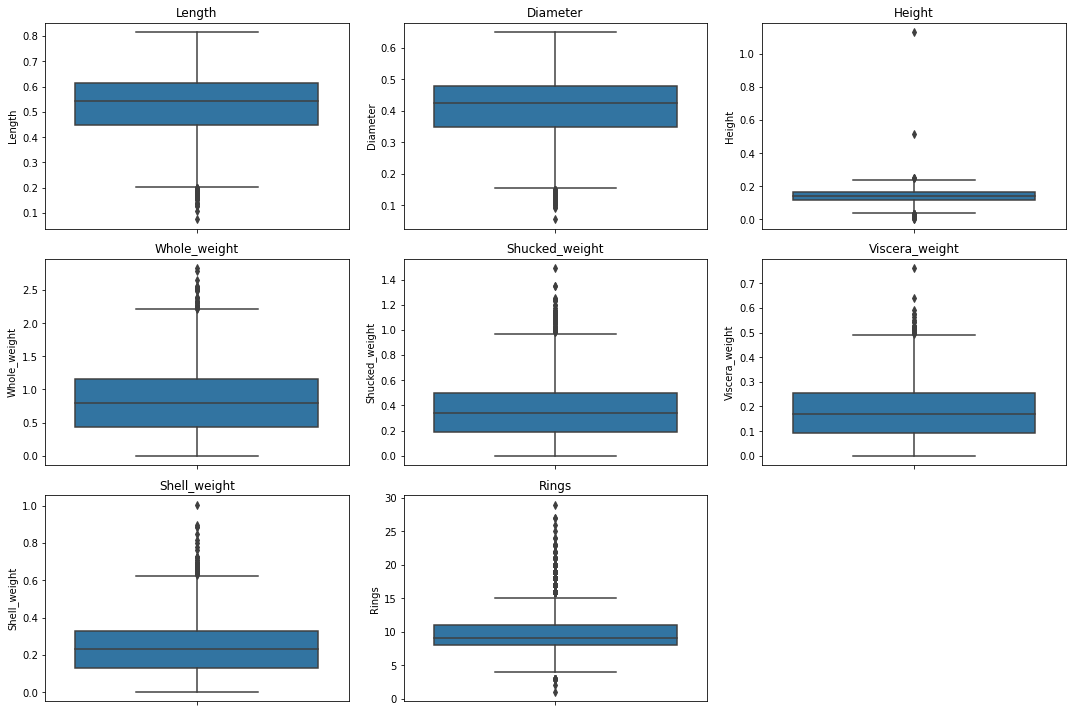

In [9]:
# Select only numerical columns
numerical_df = data_df.select_dtypes(include=['number'])
numerical_df = numerical_df.drop(columns=['Ring Age'])

# Plot box plots for each numerical column
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_df.columns, 1):
    plt.subplot(3, 3, i)  # Adjust the subplot layout depending on the number of columns
    sns.boxplot(y=data_df[column])
    plt.title(column)

plt.tight_layout()
plt.show()


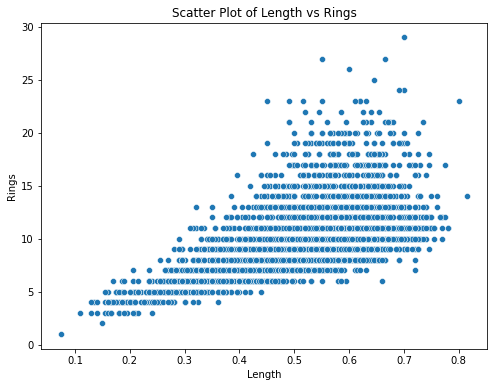

In [10]:
# Choose two variables to compare
variable1 = 'Length'
variable2 = 'Rings'

# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_df[variable1], y=data_df[variable2])
plt.title(f"Scatter Plot of {variable1} vs {variable2}")
plt.xlabel(variable1)
plt.ylabel(variable2)
plt.show()


In [11]:
# Select only numerical columns
numerical_df = data_df.select_dtypes(include=['number'])
numerical_df = numerical_df.drop(columns=['Rings', 'Ring Age'])


# Initialize a dictionary to hold outlier percentages
outlier_percentages = {}

# Calculate IQR and detect outliers for each column
for column in numerical_df.columns:
    Q1 = numerical_df[column].quantile(0.25)
    Q3 = numerical_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers
    outliers_count = numerical_df[(numerical_df[column] < lower_bound) | (numerical_df[column] > upper_bound)].shape[0]
    total_count = numerical_df.shape[0]

    # Calculate and store the percentage of outliers
    outlier_percentages[column] = (outliers_count / total_count) * 100

# Sort the columns by the percentage of outliers
sorted_outlier_percentages = sorted(outlier_percentages.items(), key=lambda x: x[1], reverse=True)

# Get the top two columns with the most significant outliers
top_two_outlier_columns = [column for column, _ in sorted_outlier_percentages[:2]]


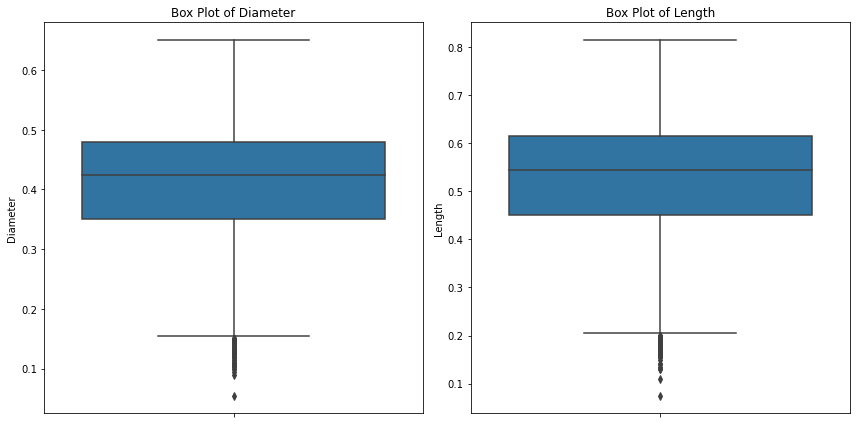

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot box plots for the two columns with the most significant outliers
plt.figure(figsize=(12, 6))

for i, column in enumerate(top_two_outlier_columns, 1):
    plt.subplot(1, 2, i)  # Layout for 2 plots
    sns.boxplot(y=data_df[column])
    plt.title(f'Box Plot of {column}')

plt.tight_layout()
plt.show()


# Visualing Classes and Features

## Distribution of 'Ring Age' classes

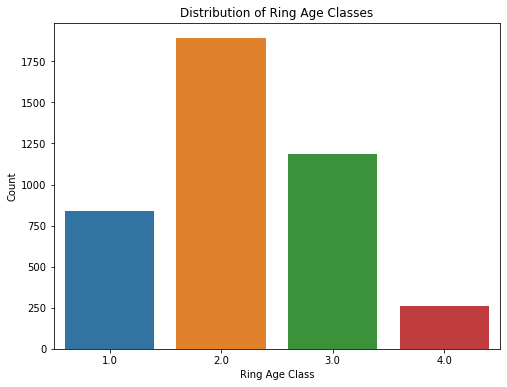

In [13]:
# 1. Distribution of 'Ring Age' classes
plt.figure(figsize=(8, 6))
sns.countplot(data=data_df, x='Ring Age')
plt.title('Distribution of Ring Age Classes')
plt.xlabel('Ring Age Class')
plt.ylabel('Count')
plt.show()

## Distribution of Features

In [81]:
data_df['Height'].describe()

count    4177.000000
mean        0.139516
std         0.041827
min         0.000000
25%         0.115000
50%         0.140000
75%         0.165000
max         1.130000
Name: Height, dtype: float64

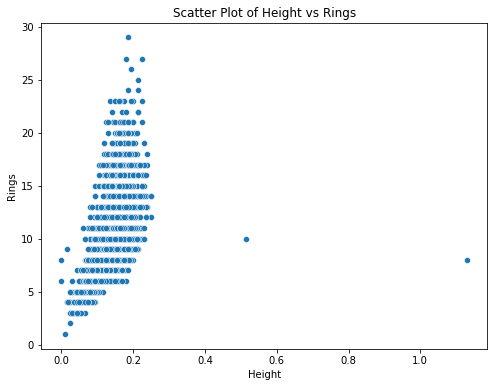

In [82]:
# prepare a scatter plot of height vs rings
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data_df, x='Height', y='Rings')
plt.title('Scatter Plot of Height vs Rings')
plt.xlabel('Height')
plt.ylabel('Rings')
plt.show()

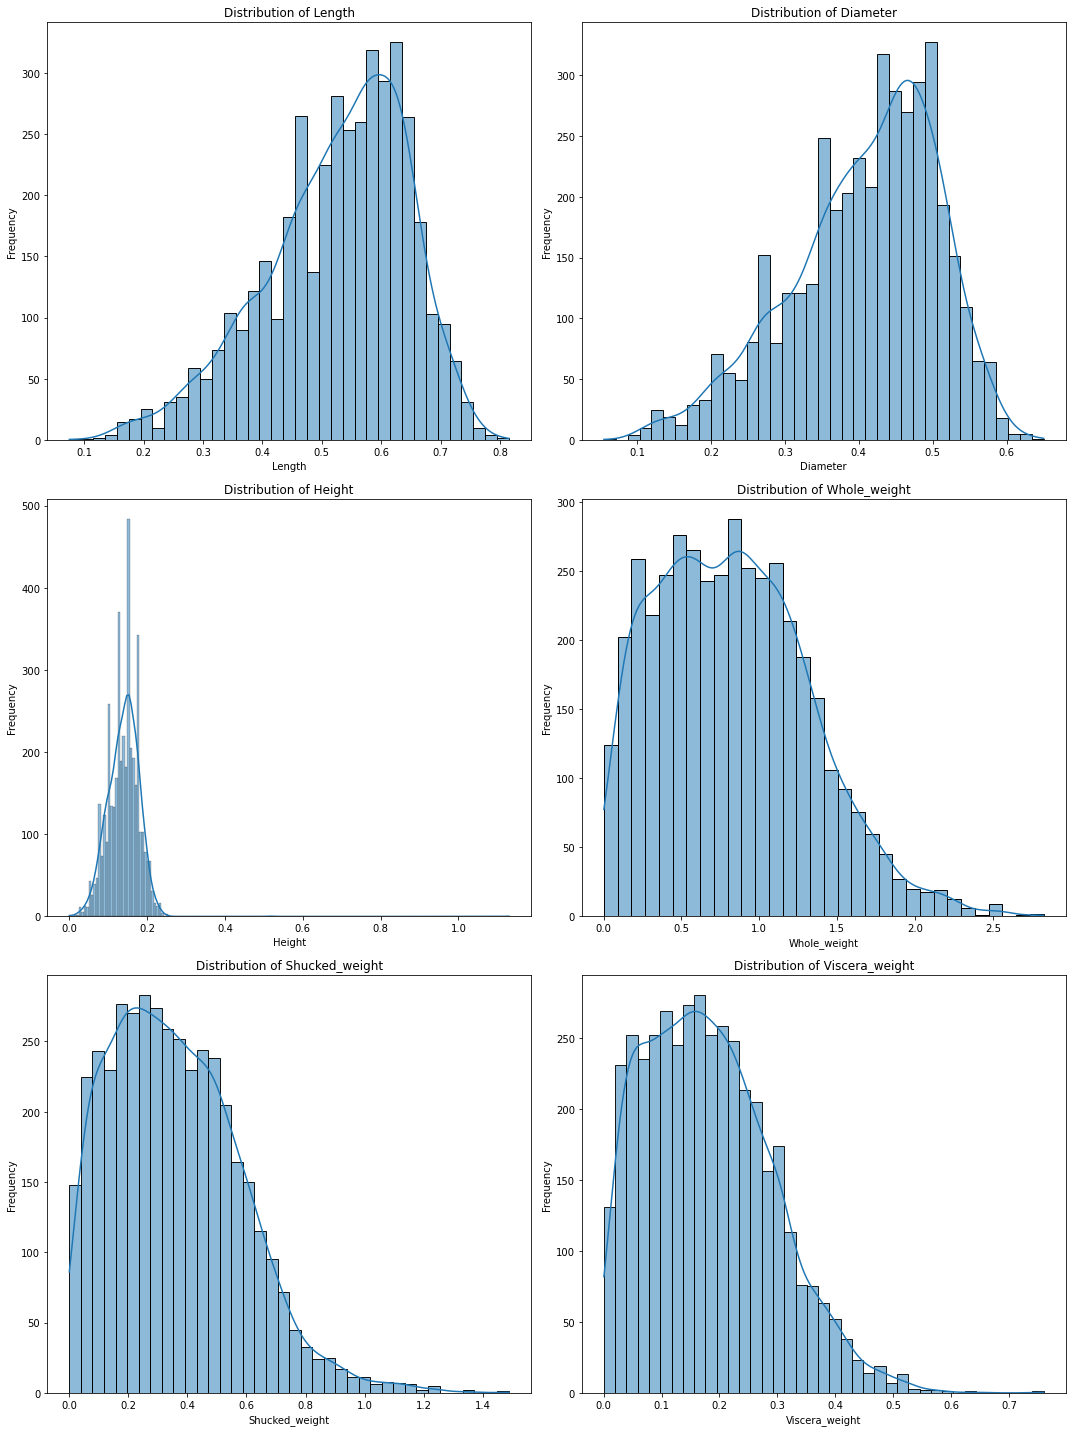

In [14]:
# Plotting Plot Distibutions in a 3x2 grid format

features = column_names[1:-2]  # Adjust according to your dataset

# Set up the matplotlib figure (3 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(15, 20))  # Adjust the size as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Plot each feature in its subplot
for i, feature in enumerate(features):
    if i < 6:  # Assuming we are only plotting the first 6 features
        sns.histplot(data=data_df, x=feature, kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')

# Adjust layout for better spacing between plots
plt.tight_layout()
plt.show()


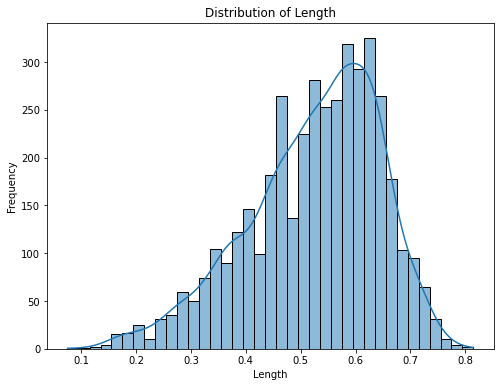

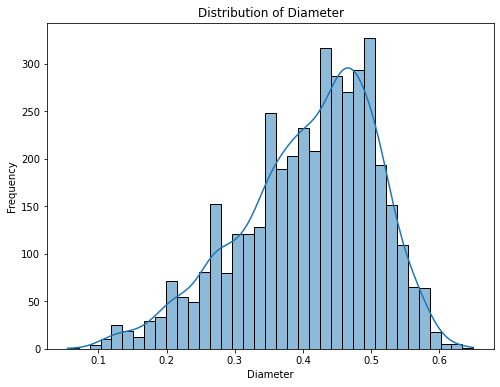

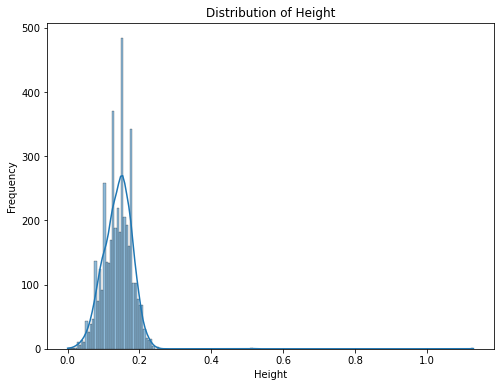

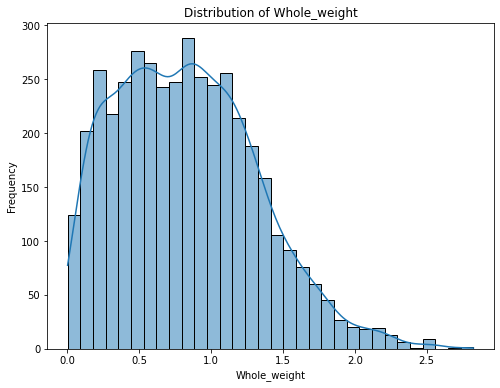

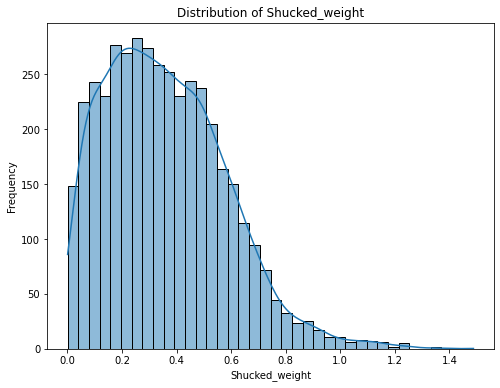

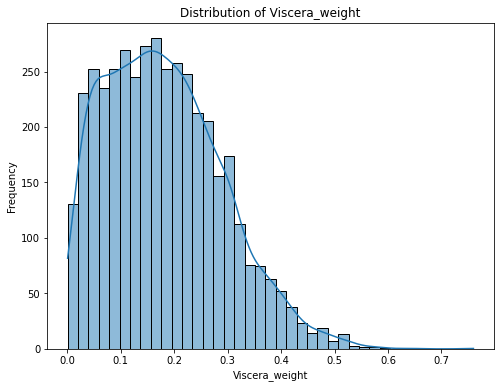

In [15]:
# Distribution of Features Individual Plots
features = column_names[1:-2]  
for feature in features:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=data_df, x=feature, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

## Boxplots for Features

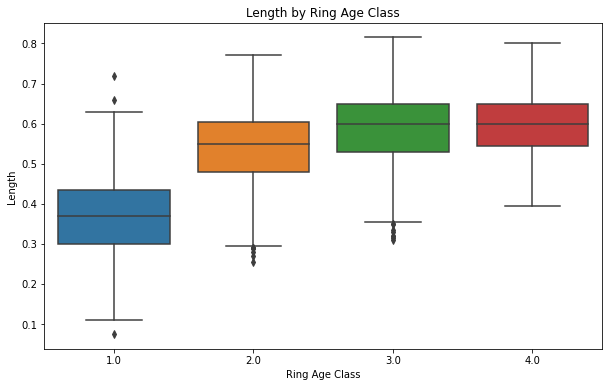

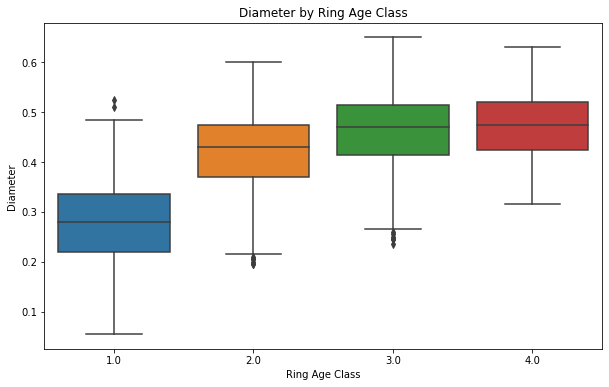

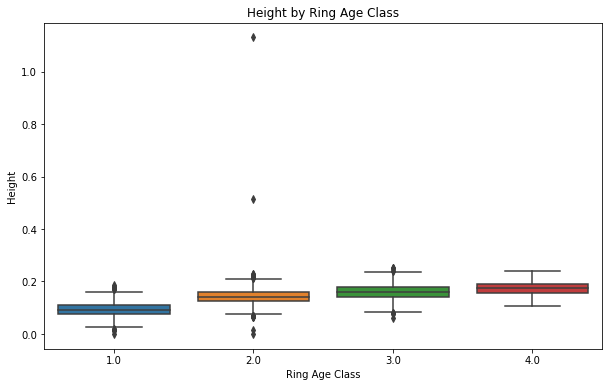

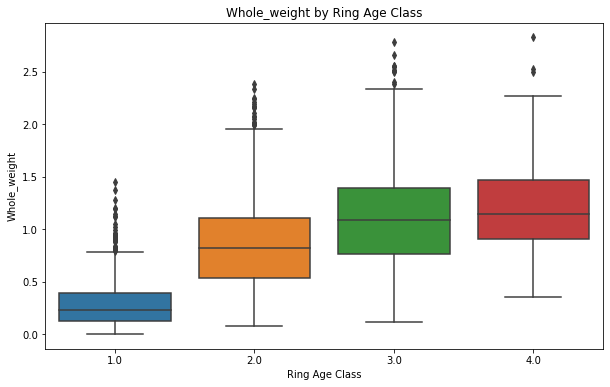

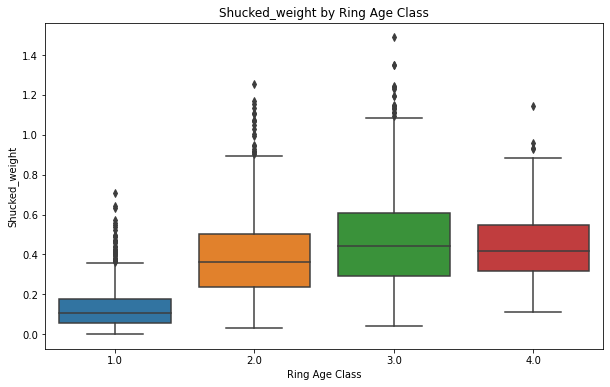

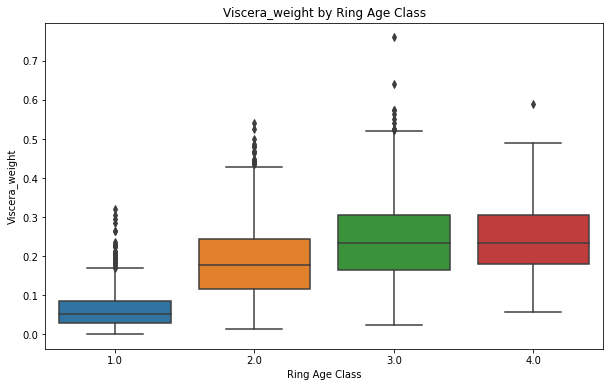

In [16]:
# Boxplot for features by 'Ring Age' class
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Ring Age', y=feature, data=data_df)
    plt.title(f'{feature} by Ring Age Class')
    plt.xlabel('Ring Age Class')
    plt.ylabel(feature)
    plt.show()

## Pairplot for a high-level overview of relationships

In [17]:

# Select a subset of features if the plot is too crowded)
#sns.pairplot(data_df, hue='Ring Age', vars=features)
#plt.show()


# Final Data Pre-procesing

In [18]:
# Encode the 'Sex' categorical variable
le = LabelEncoder()
data_df['Sex'] = le.fit_transform(data_df['Sex'])

In [19]:
data_df.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Ring Age
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,3.0
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,1.0
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,2.0
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,2.0
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,1.0


In [20]:
# Splitting the data into features and target
X = data_df.drop(['Rings','Ring Age'], axis=1)
y = data_df['Ring Age']

In [21]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42)

# Define Functions to Build and Run the Models

## Build Models

In [22]:
def build_and_run_models(hidden_layer_sizes, learning_rate_init, solver='sgd', random_state = None, max_iter=500):

    clf = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, 
                        learning_rate_init=learning_rate_init, 
                        solver=solver, 
                        activation = 'relu',
                        max_iter=max_iter, 
                        random_state=random_state)

    clf.fit(X_train, y_train)

    # Obtain the loss curve for the model
    loss_curve = clf.loss_curve_

    # Predictions
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    # Accuracy
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    # Predict probabilities for use in ROC curve
    y_score = clf.predict_proba(X_test)

    # Number of iterations that training stopped at
    num_iterations_completed = clf.n_iter_
    
    return train_accuracy, test_accuracy, loss_curve, y_pred_train, y_pred_test, y_score, num_iterations_completed

def run_experiments(hidden_neurons, learning_rates, solvers, max_iters, num_runs=10):
    i = 0
    results = {}
    loss_curves = {}
    for num_iters in max_iters:
        for neurons in hidden_neurons:
            for lr in learning_rates:
                for solver in solvers:
                    experiment_name = f"Neurons: {neurons}, LR: {lr}, Solver: {solver}, Max Iters: {num_iters}"
                    accuracies = {'train': [], 'test': []}
                    iterations_completed = [] # The iteration number the model stopped at (identifies early stopping)
                    curves = []
                    
                    best_test_acc = 0 # to help keep track of which run is the best
                    for run_num in range(1, num_runs+1):
                        if run_num == 1:
                            print(f"{i}: Running experiment: {experiment_name}")
                            i += 1
                        random_state = run_num*10 # Change the random seed for each run but make it reproducible
                        #train_acc, test_acc, curve, y_pred_train, y_pred_test, y_score = build_and_run_models((neurons,), lr, solver, random_state = random_state)
                        train_acc, test_acc, curve, y_pred_train, y_pred_test, y_score, num_iterations_completed \
                        = build_and_run_models(neurons, lr, solver, random_state = random_state, max_iter=num_iters)
                        print(f"     {random_state=}: {test_acc=}")
                        accuracies['train'].append(train_acc)
                        accuracies['test'].append(test_acc)
                        iterations_completed.append(num_iterations_completed)
                        curves.append(curve)
                        # If the accuracy for this run is the best to date, record it
                        if test_acc > best_test_acc:
                            best_test_acc = test_acc
                            # Confusion Matrix for Training Data
                            best_cm = confusion_matrix(y_test, y_pred_test)
                            best_yscore = y_score
                            best_indiv_run_result = [random_state, best_test_acc, best_cm, best_yscore, y_pred_test, y_test]

                    loss_curves[experiment_name] = curves
                    mean_train = np.mean(accuracies['train'])
                    mean_test = np.mean(accuracies['test'])
                    std_test = np.std(accuracies['test'])
                    mean_iterations_completed = np.mean(iterations_completed)
                    conf_interval_train = stats.norm.interval(0.95, loc=mean_train, scale=stats.sem(accuracies['train']))
                    conf_interval_test = stats.norm.interval(0.95, loc=mean_test, scale=stats.sem(accuracies['test']))
                    results[experiment_name] = {'train': (mean_train, conf_interval_train), 'test': (mean_test, conf_interval_test), 
                                                'stdevn_test': std_test, 'best_indiv_run': best_indiv_run_result,
                                                'mean_num_iterations_completed': mean_iterations_completed}
                
    return results, loss_curves


## Functions to Display Results

In [23]:
def display_results(results):
    
    for experiment, metrics in results.items():
        train_mean, train_conf_interval = metrics['train']
        test_mean, test_conf_interval = metrics['test']
        random_state, best_test_acc, best_cm, best_yscore, y_pred_test, y_test  = metrics['best_indiv_run']

        print(f"Experiment Configuration: {experiment}")
        print(f"  Training Data: Mean Accuracy = {train_mean:.4f}, 95% Confidence Interval = {train_conf_interval}")
        print(f"  Test Data: Mean Accuracy = {test_mean:.4f}, 95% Confidence Interval = {test_conf_interval}")
        print(f"  Test Data: Standard Deviation = {metrics['stdevn_test']:.4f}")
        print(f"  Best Individual Run: Test Accuracy = {best_test_acc:.4f}")
        print(f"  Best Individual Run Random Seed Number: {random_state}")
        print(f"  Mean Number of Iterations Completed: {metrics['mean_num_iterations_completed']:.4f}")
        print()

def results_to_dataframe(results):

    data = []
    for experiment, metrics in results.items():
        # Splitting the experiment name to extract individual parameters
        params = experiment.split("LR: ")
        print(params)
        
        lr = float(params[1].split(", ")[0])
        solver = params[1].split(", ")[1].split(": ")[1]
        num_iterations = int(params[1].split(", ")[2].split(": ")[1])
        print(f"{num_iterations=}")

        neurons = params[0]
        # Find all numbers in the string
        numbers = re.findall(r'\d+', neurons)
        neurons = int(numbers[0])
        layers = int(len(numbers))


        train_mean, train_conf_interval = metrics['train']
        test_mean, test_conf_interval = metrics['test']
        random_state, best_test_acc, best_cm, best_yscore, y_pred_test, y_test = metrics['best_indiv_run']
        
        row = {
            'Max Iterations': num_iterations,
            'Mean Number of Iterations Completed': metrics['mean_num_iterations_completed'],
            'Hidden Layers': layers,
            'Neurons': neurons,
            'Learning Rate': lr,
            'Solver': solver,
            'Train Mean Accuracy': train_mean,
            'Train 95% CI Lower': train_conf_interval[0],
            'Train 95% CI Upper': train_conf_interval[1],
            'Test Mean Accuracy': test_mean,
            'Test 95% CI Lower': test_conf_interval[0],
            'Test 95% CI Upper': test_conf_interval[1],
            'Test Standard Deviation': metrics['stdevn_test'],
            'Seed Number for Best Individual Run': random_state,
        }
        data.append(row)

    return pd.DataFrame(data)

    

## Loss Curve Plot Functions

In [24]:
# Multiple Plots Per Row

def plot_loss_curves_multi(loss_curves):
    num_experiments = len(loss_curves)
    num_cols = 2
    num_rows = num_experiments // num_cols + (1 if num_experiments % num_cols > 0 else 0)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    axs = axs.ravel()  # Flatten the array for easy iteration

    for i, (experiment, curves) in enumerate(loss_curves.items()):
        for curve in curves:
            axs[i].plot(curve, label='Run')
        axs[i].set_title(f'Loss Curve: {experiment}')
        axs[i].set_xlabel('Iterations')
        axs[i].set_ylabel('Loss')
        axs[i].legend()

    # Hide any unused subplots
    for j in range(i + 1, num_rows * num_cols):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

# Indiv Plots 
def plot_loss_curves(loss_curves):
    for experiment, curves in loss_curves.items():
        plt.figure()
        for run, curve in enumerate(curves, start=1):
            plt.plot(curve, label=f'Run {run}')

        plt.title(f'Loss Curve: {experiment}')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()


## Note: The loss curves are we are using are based on the training data
## This is because we use the below code and run the .loss_curve_ method on the clf object fitted against the training data set
"""
clf.fit(X_train, y_train)

# Obtain the loss curve for the model
loss_curve = clf.loss_curve_
"""

'\nclf.fit(X_train, y_train)\n\n# Obtain the loss curve for the model\nloss_curve = clf.loss_curve_\n'

## Bar Chart of Accuracy Results

In [25]:
def bar_chart_results(network_types, results):

    # Finding the index of the network with the highest accuracy
    max_accuracy_index = results.index(max(results))

    # Setting the color for each bar
    colors = ['skyblue' if i != max_accuracy_index else 'green' for i in range(len(network_types))]

    # Creating the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(network_types, results, color=colors)
    plt.xlabel('Networks')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy of Different Networks')
    plt.show()

## Line Chart of Accuracy Results

In [26]:
def results_line_chart(network_types, results):
    plt.plot(network_types, results, color='b', label='Test Accuracy')

    # Finding the highest accuracy and its index
    max_accuracy = max(results)
    max_index = results.index(max_accuracy)

    # Highlighting the network with the highest accuracy
    plt.scatter([network_types[max_index]], [max_accuracy], color='red', marker='x', s=100, label='Highest Accuracy')

    # Adding labels and title
    plt.xlabel('Network Types')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy of Different Networks')
    plt.legend()

    # Show the plot
    plt.show()

In [27]:
# Suppress Warnings
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress only ConvergenceWarnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
# Suppress only specific RuntimeWarnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in multiply")

# Task 2 : Effect of Number of Neurons in The Hidden Layer

In [28]:
hidden_layers_configs = [(5,), (10,), (15,), (20,)]

learning_rates = [0.01]
solvers = ['sgd']
max_iters = [200]


In [29]:
experiment_results, experiment_loss_curves = \
run_experiments(hidden_layers_configs, learning_rates, solvers, max_iters, num_runs=10)

0: Running experiment: Neurons: (5,), LR: 0.01, Solver: sgd, Max Iters: 200
     random_state=10: test_acc=0.639736684619988
     random_state=20: test_acc=0.6409335727109515
     random_state=30: test_acc=0.63016157989228
     random_state=40: test_acc=0.6343506882106523
     random_state=50: test_acc=0.6391382405745063
     random_state=60: test_acc=0.6379413524835428
     random_state=70: test_acc=0.6241771394374626
     random_state=80: test_acc=0.6343506882106523
     random_state=90: test_acc=0.6385397965290245
     random_state=100: test_acc=0.6355475763016158
1: Running experiment: Neurons: (10,), LR: 0.01, Solver: sgd, Max Iters: 200
     random_state=10: test_acc=0.6427289048473968
     random_state=20: test_acc=0.6391382405745063
     random_state=30: test_acc=0.646918013165769
     random_state=40: test_acc=0.6463195691202872
     random_state=50: test_acc=0.6451226810293238
     random_state=60: test_acc=0.6535008976660682
     random_state=70: test_acc=0.639736684619988
 

In [30]:
# Assuming experiment_results contains the results from your experiments
display_results(experiment_results)

Experiment Configuration: Neurons: (5,), LR: 0.01, Solver: sgd, Max Iters: 200
  Training Data: Mean Accuracy = 0.6477, 95% Confidence Interval = (0.6444843447688063, 0.65096657302848)
  Test Data: Mean Accuracy = 0.6355, 95% Confidence Interval = (0.6323188940433575, 0.6386565697507778)
  Test Data: Standard Deviation = 0.0049
  Best Individual Run: Test Accuracy = 0.6409
  Best Individual Run Random Seed Number: 20
  Mean Number of Iterations Completed: 200.0000

Experiment Configuration: Neurons: (10,), LR: 0.01, Solver: sgd, Max Iters: 200
  Training Data: Mean Accuracy = 0.6534, 95% Confidence Interval = (0.650731794445212, 0.6559721161693133)
  Test Data: Mean Accuracy = 0.6444, 95% Confidence Interval = (0.6418181877691608, 0.6469909085803304)
  Test Data: Standard Deviation = 0.0040
  Best Individual Run: Test Accuracy = 0.6535
  Best Individual Run Random Seed Number: 60
  Mean Number of Iterations Completed: 200.0000

Experiment Configuration: Neurons: (15,), LR: 0.01, Solver

In [31]:
# Run function to load results into a dataframe
experiment_results_df = results_to_dataframe(experiment_results)
experiment_results_df

['Neurons: (5,), ', '0.01, Solver: sgd, Max Iters: 200']
num_iterations=200
['Neurons: (10,), ', '0.01, Solver: sgd, Max Iters: 200']
num_iterations=200
['Neurons: (15,), ', '0.01, Solver: sgd, Max Iters: 200']
num_iterations=200
['Neurons: (20,), ', '0.01, Solver: sgd, Max Iters: 200']
num_iterations=200


,Max Iterations,Mean Number of Iterations Completed,Hidden Layers,Neurons,Learning Rate,Solver,Train Mean Accuracy,Train 95% CI Lower,Train 95% CI Upper,Test Mean Accuracy,Test 95% CI Lower,Test 95% CI Upper,Test Standard Deviation,Seed Number for Best Individual Run
0,200,200.0,1,5,0.01,sgd,0.647725,0.644484,0.650967,0.635488,0.632319,0.638657,0.004850,20
1,200,200.0,1,10,0.01,sgd,0.653352,0.650732,0.655972,0.644405,0.641818,0.646991,0.003959,60
2,200,200.0,1,15,0.01,sgd,0.656983,0.654434,0.659533,0.646499,0.642664,0.650334,0.005870,50
3,200,200.0,1,20,0.01,sgd,0.661772,0.660396,0.663147,0.644823,0.641252,0.648395,0.005467,90


In [32]:
# save dataframe to csv
experiment_results_df.to_csv('experiment_results_neurons.csv', index=False)

In [33]:
optimal_num_neurons = experiment_results_df.loc[experiment_results_df['Test Mean Accuracy'].idxmax(), 'Neurons']
optimal_num_neurons

15

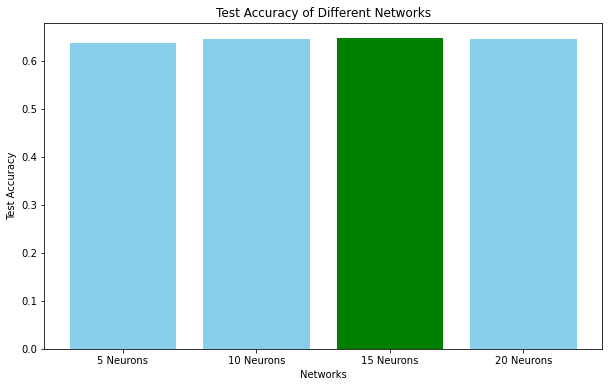

In [34]:
network_types = ['5 Neurons', '10 Neurons', '15 Neurons', '20 Neurons']
results = experiment_results_df['Test Mean Accuracy'].tolist()

bar_chart_results(network_types, results)

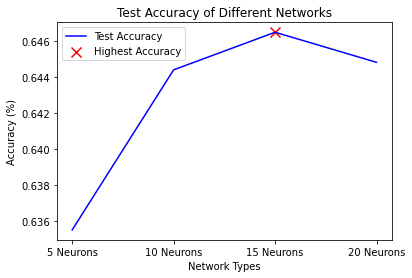

In [35]:
results_line_chart(network_types, results)

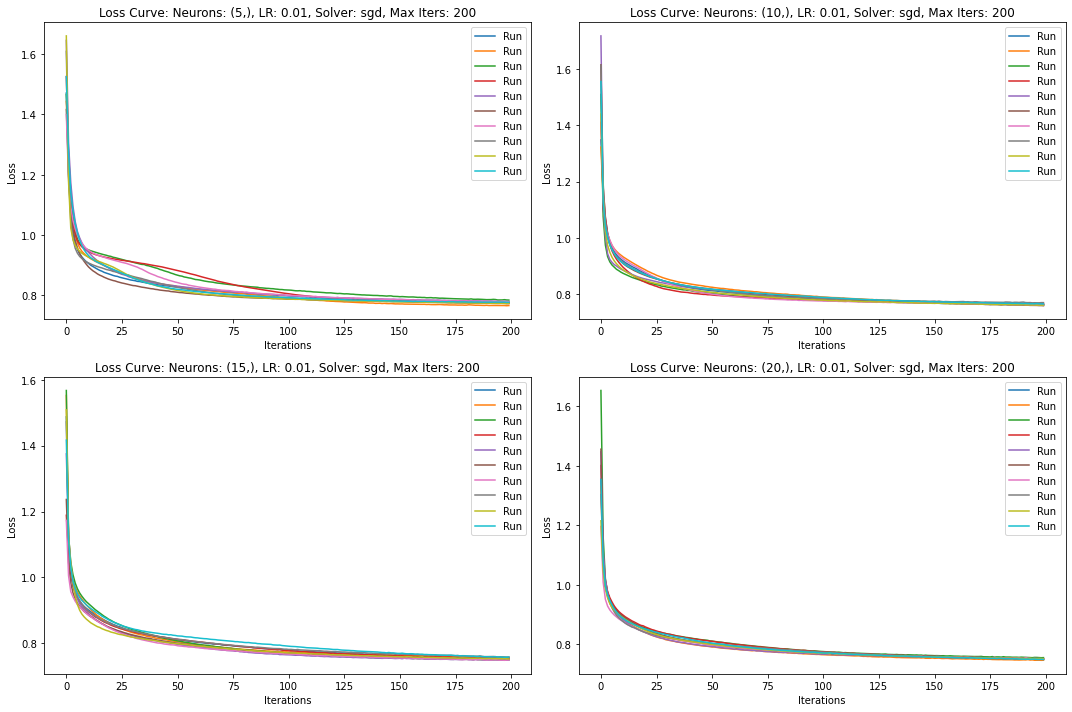

In [36]:
# Plot loss curves : Multiple Plots Per Row
plot_loss_curves_multi(experiment_loss_curves)

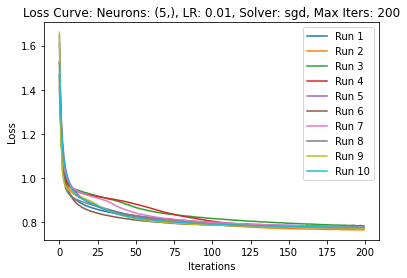

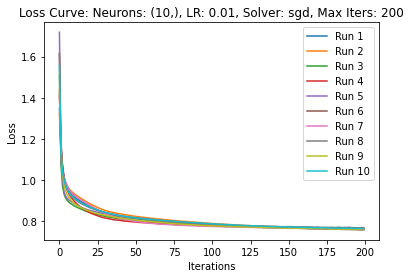

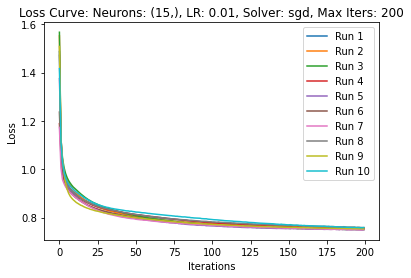

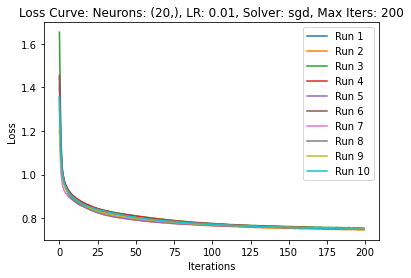

In [37]:
# Plot loss curves: Single Plot per row
plot_loss_curves(experiment_loss_curves)

# CHECKING 

## Data Checks

In [38]:
print(X.dtypes)
X.head()

Sex                 int32
Length            float64
Diameter          float64
Height            float64
Whole_weight      float64
Shucked_weight    float64
Viscera_weight    float64
Shell_weight      float64
dtype: object


,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


In [39]:
y.unique()
y[:5]

0    3.0
1    1.0
2    2.0
3    2.0
4    1.0
Name: Ring Age, dtype: float64

In [40]:
X_train[:3]

array([[ 1.15198011, -0.86603404, -0.83526087, -0.58620751, -1.10179229,
        -1.16865694, -1.12766729, -0.9004559 ],
       [ 1.15198011,  0.25823017,  0.32368636,  0.25067161, -0.15039282,
        -0.23595721, -0.2563259 ,  0.15209245],
       [-0.0643548 , -0.36636106, -0.53292681, -0.70576167, -0.77344221,
        -0.71357157, -0.8356995 , -0.71006319]])

In [41]:
y_train[:3]

542     3.0
91      3.0
4158    2.0
Name: Ring Age, dtype: float64

## Model Checks

In [42]:
learning_rate_init = 0.01
solver = 'sgd'
max_iter = 200

In [43]:
"""

# 1 Hidden layer
nn1 = MLPClassifier(hidden_layer_sizes=(8,), random_state=2, max_iter=100, activation = activation, solver=solver,  
                alpha = alpha, learning_rate_init=0.01 )
        #https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

# 2 Hidden layers
nn2 = MLPClassifier(hidden_layer_sizes=(8,4), random_state=2, max_iter=100,activation = activation, solver=solver,
                alpha = alpha, learning_rate='constant', learning_rate_init=0.01)
        #hidden_layer_sizes=(hidden,hidden, hidden) would implement 3 hidden layers

"""

"\n\n# 1 Hidden layer\nnn1 = MLPClassifier(hidden_layer_sizes=(8,), random_state=2, max_iter=100, activation = activation, solver=solver,  \n                alpha = alpha, learning_rate_init=0.01 )\n        #https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html\n\n# 2 Hidden layers\nnn2 = MLPClassifier(hidden_layer_sizes=(8,4), random_state=2, max_iter=100,activation = activation, solver=solver,\n                alpha = alpha, learning_rate='constant', learning_rate_init=0.01)\n        #hidden_layer_sizes=(hidden,hidden, hidden) would implement 3 hidden layers\n\n"

In [44]:
num_neurons_list = [5,10,15,20]
num_runs = 10
exper_num = 1


for num_nuerons in num_neurons_list:
    for run_number in range(1, num_runs+1):

        random_state = 10 * run_number

        clf = MLPClassifier(hidden_layer_sizes=(num_nuerons,), 
                                learning_rate_init=learning_rate_init, 
                                solver=solver, 
                                activation = 'relu',
                                max_iter=max_iter, 
                                random_state=random_state
                                )
        if run_number == 1:
            print(f"Experiment Number: {exper_num}  Number of Neurons: {num_nuerons} ")
        
            
        clf.fit(X_train, y_train)

        # Obtain the loss curve for the model
        #loss_curve = clf.loss_curve_

        # Predictions
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)

        # Accuracy
        train_accuracy = accuracy_score(y_train, y_pred_train)
        test_accuracy = accuracy_score(y_test, y_pred_test)
        # print train accuracy to 4 decimal places
        print(f"    Run Number: {run_number}, Train Accuracy: {train_accuracy:.4f} Test Accuracy: {test_accuracy:.4f} random_state: {random_state}")
        

    # Update Experiment Number Counter
    print()
    exper_num += 1

Experiment Number: 1  Number of Neurons: 5 
    Run Number: 1, Train Accuracy: 0.6453 Test Accuracy: 0.6397 random_state: 10
    Run Number: 2, Train Accuracy: 0.6548 Test Accuracy: 0.6409 random_state: 20
    Run Number: 3, Train Accuracy: 0.6401 Test Accuracy: 0.6302 random_state: 30
    Run Number: 4, Train Accuracy: 0.6480 Test Accuracy: 0.6344 random_state: 40
    Run Number: 5, Train Accuracy: 0.6413 Test Accuracy: 0.6391 random_state: 50
    Run Number: 6, Train Accuracy: 0.6492 Test Accuracy: 0.6379 random_state: 60
    Run Number: 7, Train Accuracy: 0.6500 Test Accuracy: 0.6242 random_state: 70
    Run Number: 8, Train Accuracy: 0.6492 Test Accuracy: 0.6344 random_state: 80
    Run Number: 9, Train Accuracy: 0.6556 Test Accuracy: 0.6385 random_state: 90
    Run Number: 10, Train Accuracy: 0.6437 Test Accuracy: 0.6355 random_state: 100

Experiment Number: 2  Number of Neurons: 10 
    Run Number: 1, Train Accuracy: 0.6556 Test Accuracy: 0.6427 random_state: 10
    Run Number: 2

# Task 3: Effect of Learning Rate

Looking at the loss curves you can see the model is often stopping before the max number of iterations is reached (particularly when we have a higher learning rate or high max number of iterations).  

This is likey due to convergence before reaching the max iterations.  That is, the model has converged to a solution before reaching the maximum number of iterations. The MLP algorithm will stop training if it determines that the loss or score has converged to a minimum. This is controlled by the tol parameter, which sets the tolerance for the optimization. If the loss improvement is smaller than tol for n_iter_no_change consecutive iterations, the training will stop.

In [45]:
optimal_num_neurons

15

In [46]:
#hidden_neurons = [optimal_num_neurons]
hidden_layers_configs = [(optimal_num_neurons,)]

learning_rates = [0.001, 0.01, 0.1]
solvers = ['sgd']

max_iters = [200, 1000]

#experiment_results, experiment_loss_curves = run_experiments(hidden_neurons, learning_rates, solvers)

experiment_results, experiment_loss_curves = \
run_experiments(hidden_layers_configs, learning_rates, solvers, max_iters, num_runs=10)



0: Running experiment: Neurons: (15,), LR: 0.001, Solver: sgd, Max Iters: 200
     random_state=10: test_acc=0.6157989228007181
     random_state=20: test_acc=0.6169958108916817
     random_state=30: test_acc=0.6110113704368642
     random_state=40: test_acc=0.6032315978456014
     random_state=50: test_acc=0.6193895870736086
     random_state=60: test_acc=0.6157989228007181
     random_state=70: test_acc=0.604428485936565
     random_state=80: test_acc=0.6104129263913824
     random_state=90: test_acc=0.6199880311190904
     random_state=100: test_acc=0.6032315978456014
1: Running experiment: Neurons: (15,), LR: 0.01, Solver: sgd, Max Iters: 200
     random_state=10: test_acc=0.644524236983842
     random_state=20: test_acc=0.6325553560742071
     random_state=30: test_acc=0.6475164572112507
     random_state=40: test_acc=0.6463195691202872
     random_state=50: test_acc=0.6558946738479952
     random_state=60: test_acc=0.651705565529623
     random_state=70: test_acc=0.64931178934769

## Experiment_results

In [47]:
# Assuming experiment_results contains the results from your experiments
display_results(experiment_results)


Experiment Configuration: Neurons: (15,), LR: 0.001, Solver: sgd, Max Iters: 200
  Training Data: Mean Accuracy = 0.6174, 95% Confidence Interval = (0.6141258263429641, 0.6206706620848093)
  Test Data: Mean Accuracy = 0.6120, 95% Confidence Interval = (0.6079653927429374, 0.616092057885429)
  Test Data: Standard Deviation = 0.0062
  Best Individual Run: Test Accuracy = 0.6200
  Best Individual Run Random Seed Number: 90
  Mean Number of Iterations Completed: 200.0000

Experiment Configuration: Neurons: (15,), LR: 0.01, Solver: sgd, Max Iters: 200
  Training Data: Mean Accuracy = 0.6570, 95% Confidence Interval = (0.6544336783655232, 0.6595328020814041)
  Test Data: Mean Accuracy = 0.6465, 95% Confidence Interval = (0.6426641453780181, 0.6503340592898453)
  Test Data: Standard Deviation = 0.0059
  Best Individual Run: Test Accuracy = 0.6559
  Best Individual Run Random Seed Number: 50
  Mean Number of Iterations Completed: 200.0000

Experiment Configuration: Neurons: (15,), LR: 0.1, Sol

## DataFrame of Results

In [48]:
# Run function to load results into a dataframe
experiment_results_df = results_to_dataframe(experiment_results)
experiment_results_df

['Neurons: (15,), ', '0.001, Solver: sgd, Max Iters: 200']
num_iterations=200
['Neurons: (15,), ', '0.01, Solver: sgd, Max Iters: 200']
num_iterations=200
['Neurons: (15,), ', '0.1, Solver: sgd, Max Iters: 200']
num_iterations=200
['Neurons: (15,), ', '0.001, Solver: sgd, Max Iters: 1000']
num_iterations=1000
['Neurons: (15,), ', '0.01, Solver: sgd, Max Iters: 1000']
num_iterations=1000
['Neurons: (15,), ', '0.1, Solver: sgd, Max Iters: 1000']
num_iterations=1000


,Max Iterations,Mean Number of Iterations Completed,Hidden Layers,Neurons,Learning Rate,Solver,Train Mean Accuracy,Train 95% CI Lower,Train 95% CI Upper,Test Mean Accuracy,Test 95% CI Lower,Test 95% CI Upper,Test Standard Deviation,Seed Number for Best Individual Run
0,200,200.0,1,15,0.001,sgd,0.617398,0.614126,0.620671,0.612029,0.607965,0.616092,0.006220,90
1,200,200.0,1,15,0.010,sgd,0.656983,0.654434,0.659533,0.646499,0.642664,0.650334,0.005870,50
2,200,90.4,1,15,0.100,sgd,0.661772,0.658138,0.665405,0.652543,0.649990,0.655096,0.003908,40
3,1000,685.3,1,15,0.001,sgd,0.645211,0.641429,0.648994,0.631358,0.628753,0.633964,0.003988,20
4,1000,332.8,1,15,0.010,sgd,0.661732,0.659941,0.663523,0.648175,0.645480,0.650869,0.004124,50
5,1000,90.4,1,15,0.100,sgd,0.661772,0.658138,0.665405,0.652543,0.649990,0.655096,0.003908,40


In [49]:
# save dataframe to csv
experiment_results_df.to_csv('experiment_results_lr.csv', index=False)

In [50]:
optimal_learning_rate = experiment_results_df.loc[experiment_results_df['Test Mean Accuracy'].idxmax(), 'Learning Rate']
optimal_learning_rate

0.1

### Bar Chart of Results

200 Max Iterations


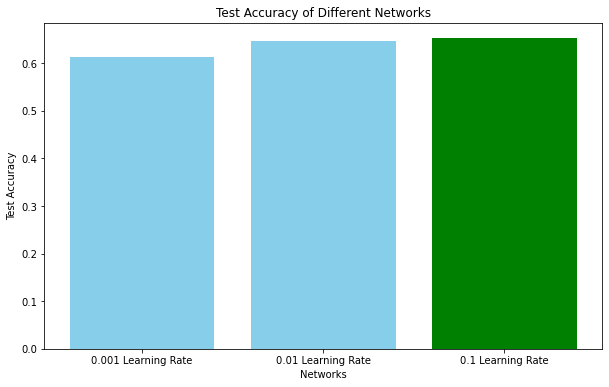

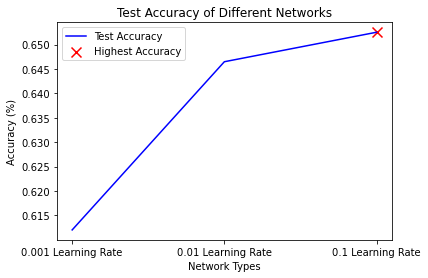

1000 Max Iterations


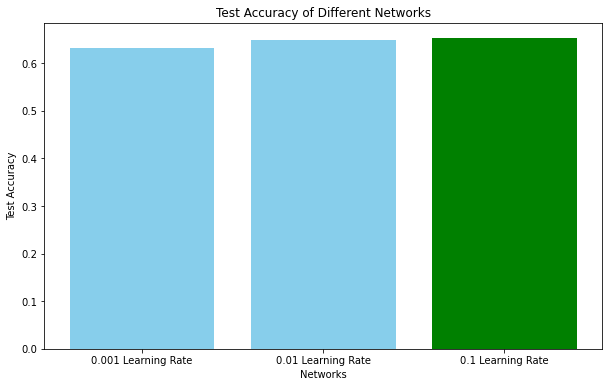

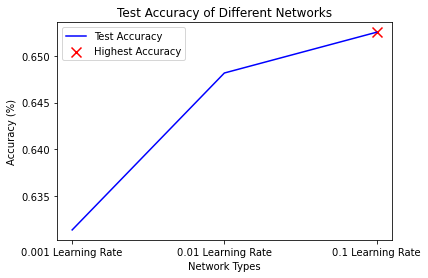

In [51]:
for iter_num in max_iters:
    network_types = ['0.001 Learning Rate', '0.01 Learning Rate', '0.1 Learning Rate']
    results = experiment_results_df[experiment_results_df['Max Iterations'] == iter_num]['Test Mean Accuracy'].tolist()

    print(f"{iter_num} Max Iterations")
    
    bar_chart_results(network_types, results)

    results_line_chart(network_types, results)

## Loss Curve Plots

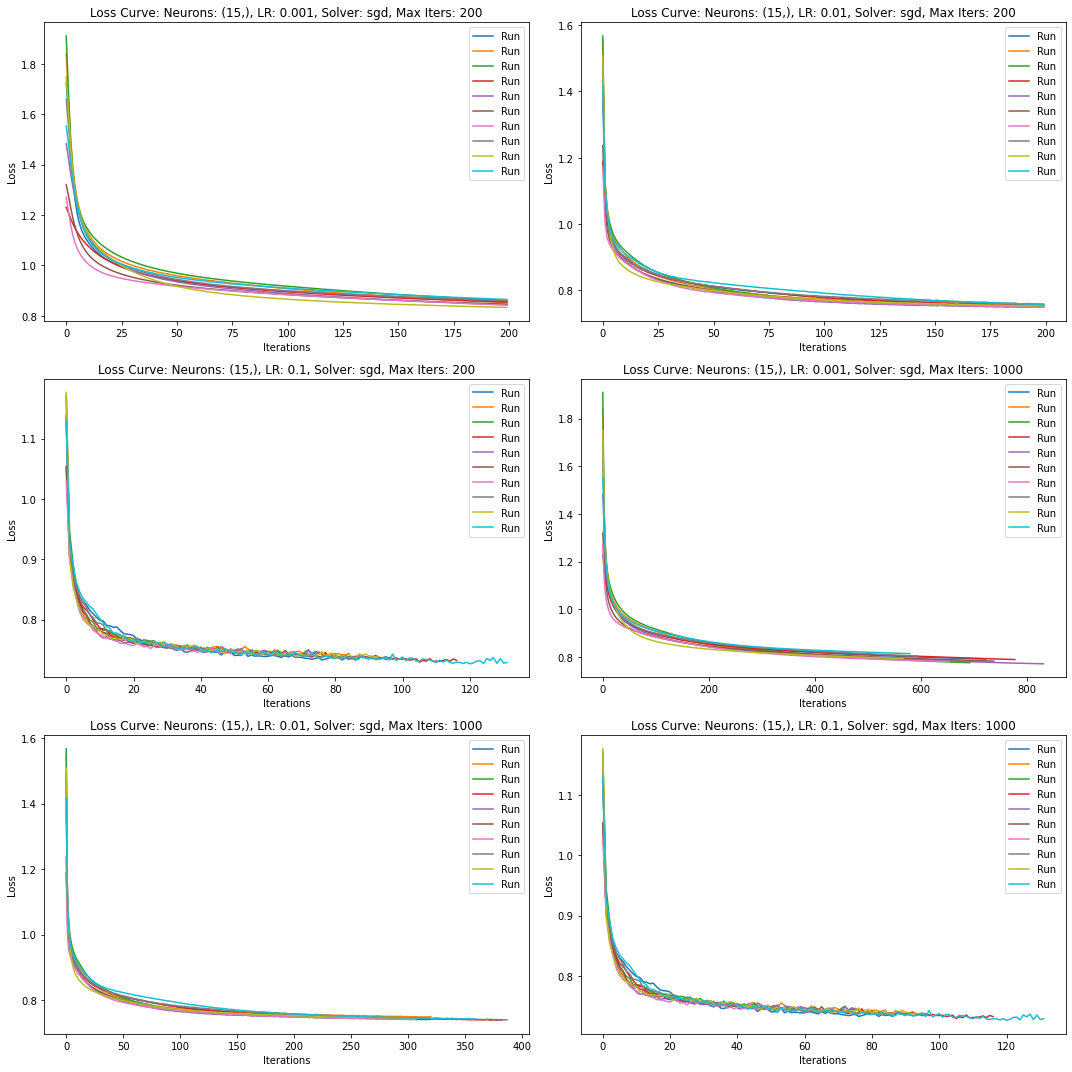

In [52]:
# Multiple Plots Per Row


# Plot loss curves
plot_loss_curves_multi(experiment_loss_curves)


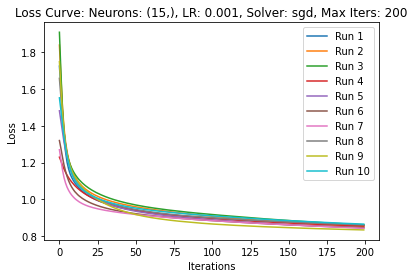

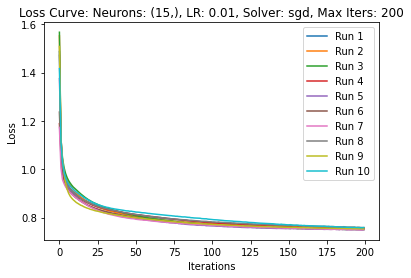

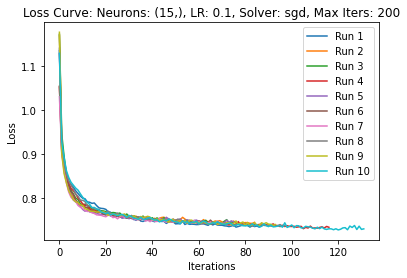

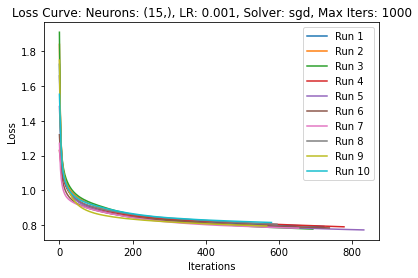

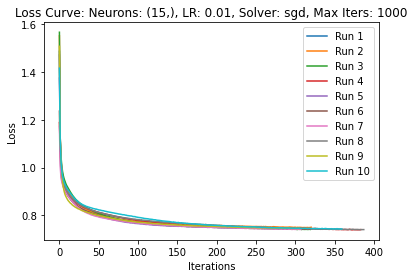

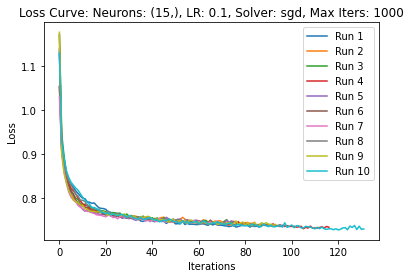

In [53]:


# Plot loss curves
plot_loss_curves(experiment_loss_curves)


# Task 4: Effect of Different Number of Layers

In [54]:
hidden_layers_configs = [(optimal_num_neurons,), (optimal_num_neurons, optimal_num_neurons)]
learning_rates = [optimal_learning_rate]
solvers = ['sgd']
max_iters = [200]

#experiment_results, experiment_loss_curves = run_experiments(hidden_layers_configs, learning_rates, solvers)

experiment_results, experiment_loss_curves = \
run_experiments(hidden_layers_configs, learning_rates, solvers, max_iters, num_runs=10)

0: Running experiment: Neurons: (15,), LR: 0.1, Solver: sgd, Max Iters: 200
     random_state=10: test_acc=0.6439257929383603
     random_state=20: test_acc=0.656493117893477
     random_state=30: test_acc=0.656493117893477
     random_state=40: test_acc=0.6576900059844405
     random_state=50: test_acc=0.6499102333931778
     random_state=60: test_acc=0.6529024536205865
     random_state=70: test_acc=0.6546977857570317
     random_state=80: test_acc=0.6523040095751047
     random_state=90: test_acc=0.6511071214841412
     random_state=100: test_acc=0.6499102333931778
1: Running experiment: Neurons: (15, 15), LR: 0.1, Solver: sgd, Max Iters: 200
     random_state=10: test_acc=0.656493117893477
     random_state=20: test_acc=0.642130460801915
     random_state=30: test_acc=0.6439257929383603
     random_state=40: test_acc=0.6487133453022143
     random_state=50: test_acc=0.6582884500299222
     random_state=60: test_acc=0.6523040095751047
     random_state=70: test_acc=0.642130460801915

In [55]:
# Run function to load results into a dataframe
experiment_results_df = results_to_dataframe(experiment_results)
experiment_results_df

['Neurons: (15,), ', '0.1, Solver: sgd, Max Iters: 200']
num_iterations=200
['Neurons: (15, 15), ', '0.1, Solver: sgd, Max Iters: 200']
num_iterations=200


,Max Iterations,Mean Number of Iterations Completed,Hidden Layers,Neurons,Learning Rate,Solver,Train Mean Accuracy,Train 95% CI Lower,Train 95% CI Upper,Test Mean Accuracy,Test 95% CI Lower,Test 95% CI Upper,Test Standard Deviation,Seed Number for Best Individual Run
0,200,90.4,1,15,0.1,sgd,0.661772,0.658138,0.665405,0.652543,0.649990,0.655096,0.003908,40
1,200,122.2,2,15,0.1,sgd,0.674741,0.671572,0.677909,0.646499,0.640658,0.652340,0.008941,50


In [56]:
# save dataframe to csv
experiment_results_df.to_csv('experiment_results_layers.csv', index=False)

In [57]:
optimal_hidden_layers = experiment_results_df.loc[experiment_results_df['Test Mean Accuracy'].idxmax(), 'Hidden Layers']
optimal_hidden_layers

1

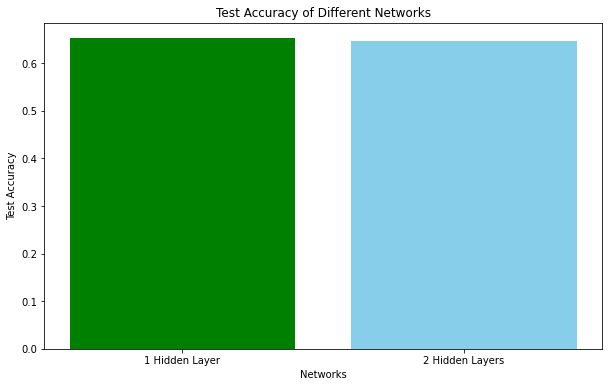

In [58]:
network_types = ['1 Hidden Layer', '2 Hidden Layers']

results = experiment_results_df['Test Mean Accuracy'].tolist()

bar_chart_results(network_types, results)

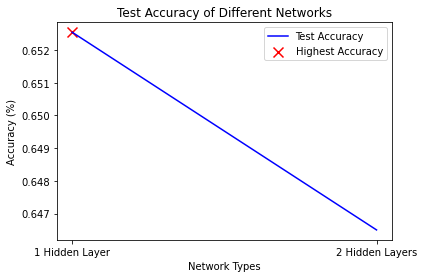

In [59]:
results_line_chart(network_types, results)

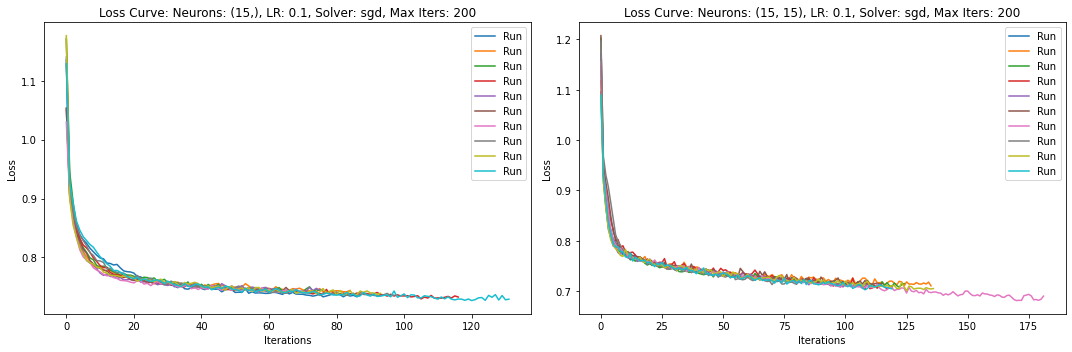

In [60]:
# Plot loss curves
plot_loss_curves_multi(experiment_loss_curves)

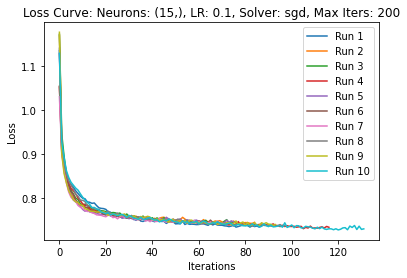

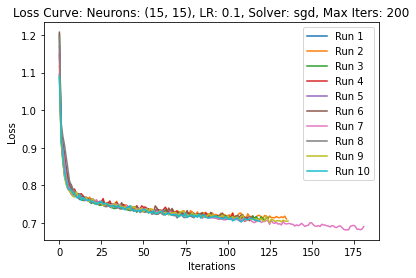

In [61]:
# Plot loss curves
plot_loss_curves(experiment_loss_curves)

# Task 5 : Effect of Adam Vs SGD

In [62]:
if optimal_hidden_layers == 1:
    hidden_layers_configs = [(optimal_num_neurons,)]
elif optimal_hidden_layers == 2:
    hidden_layers_configs = [(optimal_num_neurons,), (optimal_num_neurons)]

learning_rates = [optimal_learning_rate]

solvers = ['sgd', 'adam']
max_iters = [200]

#experiment_results, experiment_loss_curves = run_experiments(hidden_layers_configs, learning_rates, solvers)

experiment_results, experiment_loss_curves = \
run_experiments(hidden_layers_configs, learning_rates, solvers, max_iters, num_runs=10)

# Run function to load results into a dataframe
experiment_results_df = results_to_dataframe(experiment_results)
experiment_results_df

0: Running experiment: Neurons: (15,), LR: 0.1, Solver: sgd, Max Iters: 200
     random_state=10: test_acc=0.6439257929383603
     random_state=20: test_acc=0.656493117893477
     random_state=30: test_acc=0.656493117893477
     random_state=40: test_acc=0.6576900059844405
     random_state=50: test_acc=0.6499102333931778
     random_state=60: test_acc=0.6529024536205865
     random_state=70: test_acc=0.6546977857570317
     random_state=80: test_acc=0.6523040095751047
     random_state=90: test_acc=0.6511071214841412
     random_state=100: test_acc=0.6499102333931778
1: Running experiment: Neurons: (15,), LR: 0.1, Solver: adam, Max Iters: 200
     random_state=10: test_acc=0.6427289048473968
     random_state=20: test_acc=0.6367444643925793
     random_state=30: test_acc=0.6439257929383603
     random_state=40: test_acc=0.6475164572112507
     random_state=50: test_acc=0.6499102333931778
     random_state=60: test_acc=0.6373429084380611
     random_state=70: test_acc=0.641532016756433

,Max Iterations,Mean Number of Iterations Completed,Hidden Layers,Neurons,Learning Rate,Solver,Train Mean Accuracy,Train 95% CI Lower,Train 95% CI Upper,Test Mean Accuracy,Test 95% CI Lower,Test 95% CI Upper,Test Standard Deviation,Seed Number for Best Individual Run
0,200,90.4,1,15,0.1,sgd,0.661772,0.658138,0.665405,0.652543,0.649990,0.655096,0.003908,40
1,200,42.7,1,15,0.1,adam,0.649401,0.643888,0.654915,0.641053,0.637412,0.644695,0.005574,50


In [63]:
# save dataframe to csv
experiment_results_df.to_csv('experiment_results_solver.csv', index=False)

In [64]:
optimal_solver = experiment_results_df.loc[experiment_results_df['Test Mean Accuracy'].idxmax(), 'Hidden Layers']
optimal_hidden_layers

1

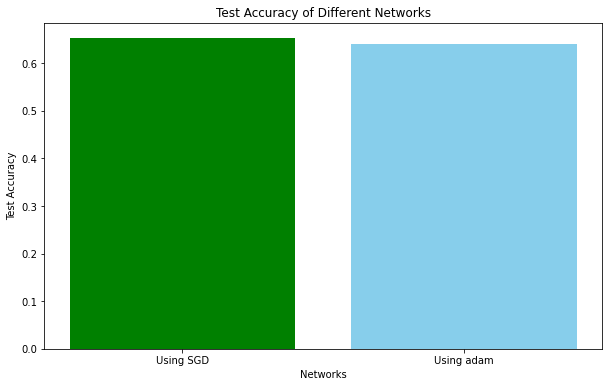

In [65]:
network_types = ['Using SGD', 'Using adam']

results = experiment_results_df['Test Mean Accuracy'].tolist()

bar_chart_results(network_types, results)

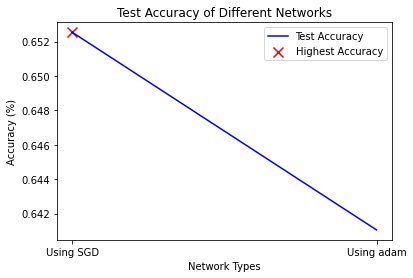

In [66]:
results_line_chart(network_types, results)

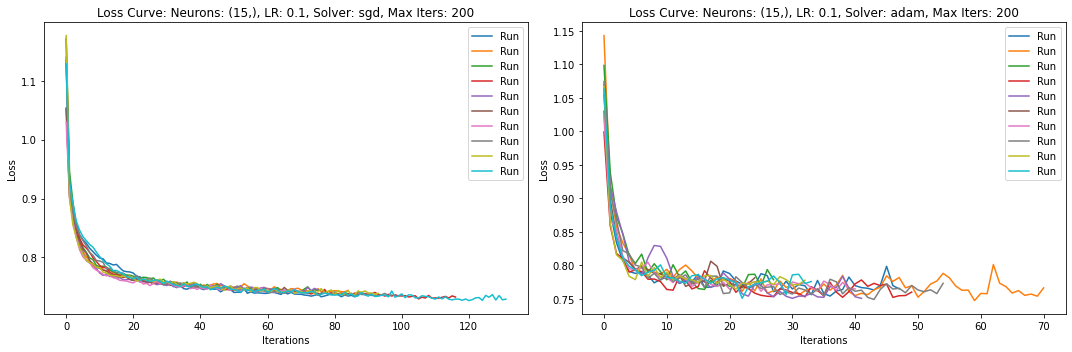

In [67]:
# Plot loss curves
plot_loss_curves_multi(experiment_loss_curves)

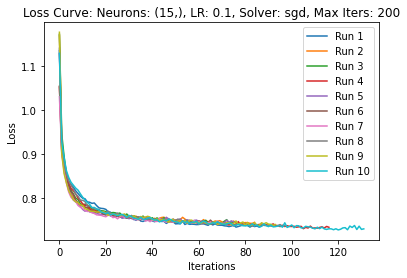

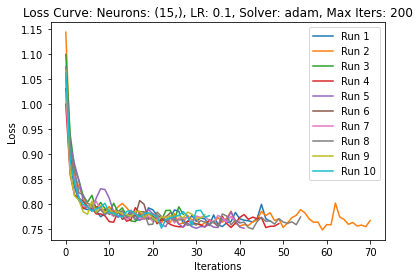

In [68]:
# Plot loss curves
plot_loss_curves(experiment_loss_curves)

# All Parameters

In [69]:
learning_rates = [0.001, 0.01, 0.1]

solvers = ['sgd', 'adam']

hidden_layers_configs = [
                        (5,), (5, 5),
                        (10,), (10, 10),
                        (15,), (15, 15),
                        (20,), (20, 20)
                        ]

max_iters = [200, 1000]




In [70]:
def main():

    experiment_results, experiment_loss_curves = \
    run_experiments(hidden_layers_configs, learning_rates, solvers, max_iters, num_runs=10)

    # Run function to load results into a dataframe
    experiment_results_df = results_to_dataframe(experiment_results)
    experiment_results_df

    display(experiment_results_df.sort_values(by=['Test Mean Accuracy'], ascending=False).head())

    display(experiment_results_df.sort_values(by=['Test Mean Accuracy'], ascending=False).tail())

    # save dataframe to csv
    #experiment_results_df.to_csv('experiment_results_all.csv', index=False)

    return experiment_results_df, experiment_results

experiment_results_df, experiment_results = main()
experiment_results_df

0: Running experiment: Neurons: (5,), LR: 0.001, Solver: sgd, Max Iters: 200
     random_state=10: test_acc=0.6134051466187912
     random_state=20: test_acc=0.6181926989826452
     random_state=30: test_acc=0.5882704967085578
     random_state=40: test_acc=0.599640933572711
     random_state=50: test_acc=0.6062238180730102
     random_state=60: test_acc=0.6026331538001197
     random_state=70: test_acc=0.5930580490724118
     random_state=80: test_acc=0.6122082585278277
     random_state=90: test_acc=0.6056253740275285
     random_state=100: test_acc=0.5978456014362658
1: Running experiment: Neurons: (5,), LR: 0.001, Solver: adam, Max Iters: 200
     random_state=10: test_acc=0.6277678037103531
     random_state=20: test_acc=0.6325553560742071
     random_state=30: test_acc=0.6152004787552364
     random_state=40: test_acc=0.6181926989826452
     random_state=50: test_acc=0.6199880311190904
     random_state=60: test_acc=0.6295631358467983
     random_state=70: test_acc=0.625972471573

,Max Iterations,Mean Number of Iterations Completed,Hidden Layers,Neurons,Learning Rate,Solver,Train Mean Accuracy,Train 95% CI Lower,Train 95% CI Upper,Test Mean Accuracy,Test 95% CI Lower,Test 95% CI Upper,Test Standard Deviation,Seed Number for Best Individual Run
92,1000,247.2,2,20,0.010,sgd,0.670710,0.667729,0.673691,0.653980,0.651129,0.656830,0.004363,60
76,1000,90.4,1,15,0.100,sgd,0.661772,0.658138,0.665405,0.652543,0.649990,0.655096,0.003908,40
28,200,90.4,1,15,0.100,sgd,0.661772,0.658138,0.665405,0.652543,0.649990,0.655096,0.003908,40
44,200,193.4,2,20,0.010,sgd,0.668236,0.666510,0.669962,0.652484,0.649820,0.655147,0.004077,60
91,1000,423.6,2,20,0.001,adam,0.678292,0.672890,0.683694,0.652244,0.648625,0.655863,0.005540,30


,Max Iterations,Mean Number of Iterations Completed,Hidden Layers,Neurons,Learning Rate,Solver,Train Mean Accuracy,Train 95% CI Lower,Train 95% CI Upper,Test Mean Accuracy,Test 95% CI Lower,Test 95% CI Upper,Test Standard Deviation,Seed Number for Best Individual Run
24,200,200.0,1,15,0.001,sgd,0.617398,0.614126,0.620671,0.612029,0.607965,0.616092,0.006220,90
36,200,200.0,1,20,0.001,sgd,0.620271,0.617384,0.623158,0.611430,0.608347,0.614514,0.004720,80
12,200,200.0,1,10,0.001,sgd,0.612809,0.608816,0.616802,0.607899,0.605319,0.610480,0.003950,10
0,200,200.0,1,5,0.001,sgd,0.605068,0.598271,0.611864,0.603710,0.597904,0.609517,0.008888,20
6,200,200.0,2,5,0.001,sgd,0.594653,0.578815,0.610491,0.599701,0.587936,0.611466,0.018008,90


,Max Iterations,Mean Number of Iterations Completed,Hidden Layers,Neurons,Learning Rate,Solver,Train Mean Accuracy,Train 95% CI Lower,Train 95% CI Upper,Test Mean Accuracy,Test 95% CI Lower,Test 95% CI Upper,Test Standard Deviation,Seed Number for Best Individual Run
0,200,200.0,1,5,0.001,sgd,0.605068,0.598271,0.611864,0.603710,0.597904,0.609517,0.008888,20
1,200,200.0,1,5,0.001,adam,0.631285,0.626087,0.636483,0.624357,0.621016,0.627697,0.005113,20
2,200,200.0,1,5,0.010,sgd,0.647725,0.644484,0.650967,0.635488,0.632319,0.638657,0.004850,20
3,200,141.8,1,5,0.010,adam,0.647287,0.645571,0.649002,0.638300,0.636631,0.639970,0.002556,40
4,200,81.2,1,5,0.100,sgd,0.650599,0.645608,0.655589,0.643986,0.640043,0.647928,0.006035,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,1000,423.6,2,20,0.001,adam,0.678292,0.672890,0.683694,0.652244,0.648625,0.655863,0.005540,30
92,1000,247.2,2,20,0.010,sgd,0.670710,0.667729,0.673691,0.653980,0.651129,0.656830,0.004363,60
93,1000,140.3,2,20,0.010,adam,0.689226,0.682797,0.695655,0.639916,0.635967,0.643865,0.006044,40
94,1000,133.5,2,20,0.100,sgd,0.685076,0.672169,0.697983,0.646679,0.639808,0.653550,0.010517,30


## Details of the Top Performing Run

In [71]:
# Identify the index of the row with the highest mean test accuracy
max_accuracy_index = experiment_results_df['Test Mean Accuracy'].idxmax()
max_accuracy_index

"""
Our best run df differs from experiement results df in that the scores given are for the best run of the 10 runs for that experiement (not the mean)
"""

best_run_array = []
for key, value in experiment_results.items():
    random_state, best_test_acc, best_cm, best_yscore, y_pred_test, y_test = value['best_indiv_run']
    # append the key and the contents of the value['best_indiv_run'] to the best_run_array

    best_run_array.append([key, random_state, best_test_acc, best_cm, best_yscore, y_pred_test, y_test])
    

# Create a dataframe from the best_run_array
best_run_df = pd.DataFrame(best_run_array, columns=['Experiment', 'Random State', 'Best Test Accuracy', 'Confusion Matrix', 'Y Score', 'Y Pred Test', 'Y Test'])
#best_run_df = best_run_df.sort_values(by=['Best Test Accuracy'], ascending=False).reset_index(drop=True)

top_performing_run = best_run_df.loc[[max_accuracy_index],:]
print(f"The details of the top performing run for the Model which had the highest mean test accuracy:")
display(top_performing_run)

print(('----------'))

print(experiment_results_df.sort_values(by=['Test Mean Accuracy'], ascending=False).head(1))

#best_run_df.head(2)

The details of the top performing run for the Model which had the highest mean test accuracy:


,Experiment,Random State,Best Test Accuracy,Confusion Matrix,Y Score,Y Pred Test,Y Test
92,"Neurons: (20, 20), LR: 0.01, Solver: sgd, Max ...",60,0.662478,"[[261, 102, 2, 0], [46, 561, 142, 3], [8, 174,...","[[0.0021084284809144496, 0.3812846360278817, 0...","[3.0, 2.0, 3.0, 2.0, 3.0, 2.0, 2.0, 2.0, 1.0, ...",866 2.0 1483 2.0 599 4.0 1702 2....


----------
    Max Iterations  Mean Number of Iterations Completed  Hidden Layers  \
92            1000                                247.2              2   

    Neurons  Learning Rate Solver  Train Mean Accuracy  Train 95% CI Lower  \
92       20           0.01    sgd              0.67071            0.667729   

    Train 95% CI Upper  Test Mean Accuracy  Test 95% CI Lower  \
92            0.673691             0.65398           0.651129   

    Test 95% CI Upper  Test Standard Deviation  \
92            0.65683                 0.004363   

    Seed Number for Best Individual Run  
92                                   60  


### Confusion Matrix

In [72]:
# Load the confusion matrix into a dataframe
cm_df = pd.DataFrame(top_performing_run['Confusion Matrix'].values[0], columns=['Predicted 1', 'Predicted 2', 'Predicted 3', 'Predicted 4'])
cm_df.index = ['Actual 1', 'Actual 2', 'Actual 3', 'Actual 4']
# save the df to csv
cm_df.to_csv('cm_df.csv')
cm_df


,Predicted 1,Predicted 2,Predicted 3,Predicted 4
Actual 1,261,102,2,0
Actual 2,46,561,142,3
Actual 3,8,174,260,20
Actual 4,0,11,56,25


In [73]:
# Give precision, recall, f1-score and support for each class
report = classification_report(top_performing_run['Y Test'].values[0], top_performing_run['Y Pred Test'].values[0], output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv('cm_report_df.csv')
report_df

,precision,recall,f1-score,support
1.0,0.828571,0.715068,0.767647,365.000000
2.0,0.661557,0.746011,0.701250,752.000000
3.0,0.565217,0.562771,0.563991,462.000000
4.0,0.520833,0.271739,0.357143,92.000000
accuracy,0.662478,0.662478,0.662478,0.662478
macro avg,0.644045,0.573897,0.597508,1671.000000
weighted avg,0.663654,0.662478,0.658858,1671.000000


In [74]:
# Santity Check on CM Values

top_performing_run['Y Test'].values[0]
# count the district values in the y_test array
unique, counts = np.unique(top_performing_run['Y Test'].values[0], return_counts=True)
print('Y Test', unique, counts)
unique, counts = np.unique(top_performing_run['Y Pred Test'].values[0], return_counts=True)
print('Y Pred', unique, counts)

Y Test [1. 2. 3. 4.] [365 752 462  92]
Y Pred [1. 2. 3. 4.] [315 848 460  48]


### ROC_Curve, AUC

In [75]:
top_performing_run

,Experiment,Random State,Best Test Accuracy,Confusion Matrix,Y Score,Y Pred Test,Y Test
92,"Neurons: (20, 20), LR: 0.01, Solver: sgd, Max ...",60,0.662478,"[[261, 102, 2, 0], [46, 561, 142, 3], [8, 174,...","[[0.0021084284809144496, 0.3812846360278817, 0...","[3.0, 2.0, 3.0, 2.0, 3.0, 2.0, 2.0, 2.0, 1.0, ...",866 2.0 1483 2.0 599 4.0 1702 2....


In [76]:
top_performing_run['Y Score'].values[0]

array([[2.10842848e-03, 3.81284636e-01, 5.50727157e-01, 6.58797782e-02],
       [2.07403719e-02, 8.27178188e-01, 1.45175803e-01, 6.90563709e-03],
       [1.63383753e-04, 5.44997903e-02, 5.88938619e-01, 3.56398207e-01],
       ...,
       [2.53142452e-03, 5.16560431e-01, 4.24380423e-01, 5.65277207e-02],
       [7.77853364e-01, 2.15213934e-01, 6.49394636e-03, 4.38755555e-04],
       [9.19160588e-02, 8.90572229e-01, 1.71027673e-02, 4.08944987e-04]])

In [77]:
top_performing_run['Y Test'].values[0]

866     2.0
1483    2.0
599     4.0
1702    2.0
670     3.0
       ... 
3604    2.0
3223    2.0
2350    3.0
3534    1.0
845     2.0
Name: Ring Age, Length: 1671, dtype: float64

In [78]:

y_test_binarized = label_binarize(top_performing_run['Y Test'].values[0], classes=np.unique(top_performing_run['Y Test'].values[0]))
y_test_binarized

array([[0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       ...,
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0]])

In [79]:

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 4


# Binarize the y_test for multi-class ROC computation
y_test_binarized = label_binarize(top_performing_run['Y Test'].values[0], classes=np.unique(top_performing_run['Y Test'].values[0]))
y_score = top_performing_run['Y Score'].values[0]


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(f"ROC AUC for Class {i+1}: {roc_auc[i]:.4f}")
    

ROC AUC for Class 1: 0.9461
ROC AUC for Class 2: 0.7829
ROC AUC for Class 3: 0.8034
ROC AUC for Class 4: 0.9046


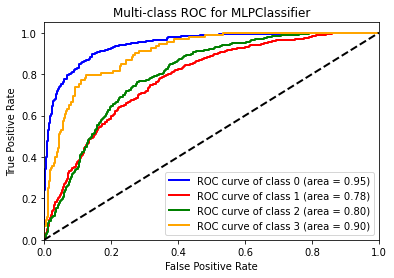

In [80]:
# Plot all ROC curves
plt.figure()

colors = ['blue', 'red', 'green', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC for MLPClassifier')
plt.legend(loc="lower right")
plt.show()

# END OF CODE

# working Notes

## References

ADAM: A Method for Stochastic Optimization" (Kingma and Ba, 2015): This paper introduced the ADAM algorithm, which is a method for optimizing the parameters of neural networks. The ADAM algorithm is very efficient and has been widely used in deep learning.

Neural Networks
Neural networks have attracted a vast amount of theoretical research and commercial software development. The discussion here is confined to their application in the classification problem. The basic purpose of introducing neural networks in this problem is to allow a flexible classification boundary: in fact, mathematical theory states that, under certain conditions, neural networks can approximate an arbitrarily complex boundary. However, this flexibility comes with two main costs. First, complex models require complex computation. Neural network models are typically nonlinear, with hundreds or thousands of parameters, and fitting these models to data presents a formidable computational challenge. Indeed, more research effort has been devoted to fast computing for neural networks than to their theoretical properties. Even with modern computers and software, convergence of the iterative routines used to fit these models on large data sets can take significant time. Second, neural network models do not admit a mathematical or computational description that is at once transparent and precise, so it is difficult to understand their behavior except phenomenologically, by looking at results such as misclassification tables. In a sense, a neural network is a black box, and it is hard to open the box.

John A. Bunge, Dean H. Judson, in Encyclopedia of Social Measurement, 2005

Standard Error of the Mean (SEM): SEM is a measure of how much discrepancy there is likely to be in our estimate of the mean accuracy. It is calculated as the standard deviation of the sample accuracies divided by the square root of the number of runs.

95% Confidence Interval: Using the mean accuracy and SEM, a 95% confidence interval is calculated. In the code, this is done using stats.norm.interval(0.95, loc=mean, scale=stats.sem(accuracies)). This function assumes a normal distribution and calculates the range within which the true mean accuracy is likely to lie with 95% confidence.

0.95 is the confidence level.
loc=mean is the mean accuracy calculated earlier.
scale=stats.sem(accuracies) is the standard error of the mean.
So, when we say "the 95% confidence interval has been achieved," it means that the calculated interval is the range in which we are 95% confident that the true mean accuracy lies, based on the sample data we have. This doesn't guarantee that the true mean is within this range, but it is very likely based on standard statistical assumptions.

The contents of the `experiment_results_df` DataFrame provide insightful information about the performance of various configurations of a neural network on your dataset. Here's an analysis based on the provided data:

1. **No Missing Values and Outliers:** The dataset has no missing values in any of the columns, which is good for model training. Also, there are a significant number of rows with outliers (396), which might affect the model's performance. Depending on the nature of these outliers, you might want to consider handling them (e.g., removing or transforming them) to improve model robustness.

2. **Experiment Configurations:** The experiments vary by the number of neurons in the hidden layer (5, 10, 15, 20), learning rate (0.001, 0.01, 0.1), and solver (adam, sgd). This range of parameters allows for a comprehensive understanding of how each factor influences model performance.

3. **High Accuracies with Certain Configurations:** Several configurations, especially those with a learning rate of 0.01 and 0.1, are achieving very high accuracies, close to 1.0 (100%). This could indicate a very well-fitting model, but it also raises concerns about potential overfitting, especially if these results are not consistent with the complexity of the problem or the quality of the dataset.

4. **Confidence Intervals:** In several cases, especially where accuracies are 1.0, the 95% confidence intervals are not computable (shown as NaN). This usually happens when the variance in the accuracy across runs is extremely low or zero, often a sign of overfitting. A model performing perfectly across multiple runs can indicate that it has memorized the training data, especially in cases where the test data is not sufficiently challenging or diverse.

5. **Solver Performance:** The 'adam' solver seems to generally perform better than 'sgd', particularly at lower learning rates. This is consistent with the general understanding that Adam optimization is more efficient and effective in many scenarios compared to traditional Stochastic Gradient Descent.

6. **Effect of Learning Rate and Neurons:** Higher learning rates (0.01 and 0.1) tend to give higher accuracies in this dataset, regardless of the number of neurons. However, this again should be cautiously interpreted in terms of potential overfitting.

7. **General Observations:** 
   - Lower learning rates (0.001) with the SGD solver tend to have lower performance.
   - Increasing the number of neurons does not always lead to better performance. For example, configurations with 5 neurons sometimes perform comparably or even better than those with more neurons.

### Recommendations:
- **Investigate Overfitting:** Given the high accuracies, investigate whether the model is overfitting. This can be done by checking the model's performance on a completely separate validation set, if available.
- **Analyze Data Complexity:** Ensure that the high accuracies align with the expected complexity of the data. If the data problem is not trivial, such high accuracies might be suspicious.
- **Outliers Handling:** Consider revisiting the outlier handling strategy, as they might affect the model's ability to generalize.
- **Experiment with More Configurations:** If computational resources allow, experimenting with more diverse configurations can provide further insights, especially in terms of neurons and hidden layers.